# Word2Vec (Negative Sampling)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.23.5', '1.13.1')

In [3]:
import matplotlib
matplotlib.__version__

'3.6.3'

## 1. Load data

In [4]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", "grape apple apple", 
        "dog cat animal", "cat dog animal", "cat animal dog", "fish dog dog"]

In [5]:
#1. tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['grape', 'apple', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog'],
 ['fish', 'dog', 'dog']]

In [6]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [7]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['dog']

7

In [8]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [9]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'fish'

## 2. Prepare train data

In [10]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
x, y = random_batch(2, corpus)

In [11]:
x.shape  #batch_size, 1

(2, 1)

In [12]:
x

array([[3],
       [7]])

In [13]:
y.shape  #batch_size 1

(2, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [14]:
z = 0.001

In [16]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

24

In [17]:
vocabs

['cat', 'banana', 'animal', 'fruit', 'grape', 'fish', 'apple', 'dog', '<UNK>']

$$P(w)=U(w)^{3/4}/Z$$

In [25]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'cat': 210,
         'banana': 210,
         'animal': 210,
         'fruit': 210,
         'grape': 92,
         'fish': 92,
         'apple': 308,
         'dog': 308})

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [26]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [27]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [28]:
batch_size = 2
x, y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [29]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [33]:
y_tensor[1]

tensor([1])

In [34]:
neg_samples[1]

tensor([5, 2, 2, 2, 5])

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [35]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [38]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [40]:
loss = model(x_tensor, y_tensor, neg_samples)

In [41]:
loss

tensor(1.2440, grad_fn=<NegBackward0>)

## 5. Training

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 1.096912
Epoch   2000 | Loss: 0.941332
Epoch   3000 | Loss: 0.729202
Epoch   4000 | Loss: 1.107407
Epoch   5000 | Loss: 0.521701
Epoch   6000 | Loss: 1.008388
Epoch   7000 | Loss: 1.310975
Epoch   8000 | Loss: 0.390962
Epoch   9000 | Loss: 0.718655
Epoch  10000 | Loss: 0.294141


## 6. Plot the embeddings

In [45]:
vocabs

['cat', 'banana', 'animal', 'fruit', 'grape', 'fish', 'apple', 'dog', '<UNK>']

In [46]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([1])

In [47]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[-1.2169,  0.2680]], grad_fn=<DivBackward0>)

In [48]:
banana_embed_o

tensor([[-1.8857, -0.3113]], grad_fn=<EmbeddingBackward0>)

In [49]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [50]:
get_embed('fruit')

(-1.6248319149017334, 0.41915708780288696)

In [51]:
get_embed('cat')

(1.3170452117919922, -0.7658721208572388)

In [52]:
get_embed('dog')

(1.7207331657409668, -0.2711341679096222)

In [53]:
get_embed('banana')

(-1.2168848514556885, 0.26804348826408386)

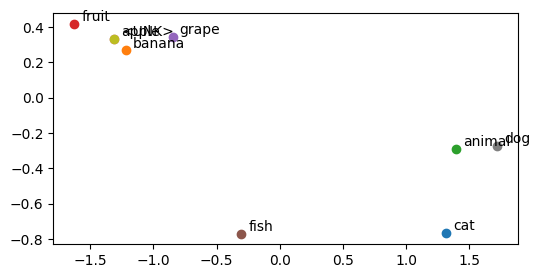

In [54]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

In [61]:
banana = get_embed('banana')
banana

(-1.2168848514556885, 0.26804348826408386)

In [62]:
fruit = get_embed('fruit')
fruit

(-1.6248319149017334, 0.41915708780288696)

In [63]:
cat = get_embed('cat')
cat

(1.3170452117919922, -0.7658721208572388)

In [66]:
np.array(banana) @ np.array(cat)

-1.8079794017507105

In [65]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(cat)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

-0.9523630610360275
0.9993643506202321
